# Trabalho computacional 

Esse trabalho computacional tem o objetivo de modelar e projetar o controle de um motor de corrente contínua (CC) utilizando espaços de estados.

## 1. Análise do sistema

### Dependências necessárias e funções auxiliares

In [2]:
# dependências necessárias
import control as ct 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Image

# funções necessárias

### Modelagem física

A modelagem física do motor conduz ao seguinte sistema de equações

$$
\begin{cases}
V_t(t) = L_a \frac{d i_a(t)}{dt} + R_a i_a(t) + E_a(t) \\
E_a(t) = K_e \omega(t) \\
\omega(t) = \frac{d \theta(t)}{dt} \\
\tau_{ele}(t) - \tau_L(t) = J \frac{d \omega(t)}{dt} + b \omega(t) \\
\tau_{ele} = K_{\tau} i_a(t) \\
\tau_L(t) = J_L \frac{d \omega(t)}{dt} + b_L \omega(t)
\end{cases}
$$



| Variável | Descrição |
| :--- | :--- |
| $V_t(t)$ | tensão terminal (V) |
| $E_a(t)$ | força contra-eletromotriz (V) |
| $i_a(t)$ | corrente de armadura (A) |
| $\tau_{ele}(t)$ | torque da máquina (N.m) |
| $\tau_L(t)$ | torque de carga (N.m) |
| $\omega(t)$ | velocidade do eixo (rad/s) |
| $\theta(t)$ | posição do eixo (rad) |

### Parâmetros do motor
Os parâmetros do motor são apresentados na tabela a seguir:

| Variável | Descrição | Valor |
| :--- | :--- | :--- |
| $L_a$ | indut. armadura | 1,3 H |
| $R_a$ | resist. armadura | 0,3 $\Omega$ |
| $J$ | mom. inércia MCC | 0,0013 $kg.m^2$ |
| $b$ | amort. rotacional MCC | 0,00169 $N.m.s/rad$ |
| $J_L$ | mom. inércia de carga | 0,036056 $kg.m^2$ |
| $K_e$ | constante construtiva | 0,0055678 $'.s/rad$ |
| $K_{\tau}$ | constante construtiva | 0,23077 $N.m/A$ |
| $b_L$ | amort. rotacional carga | 0,0169 $N.m.s/rad$ |

### Diagrama de blocos do sistema

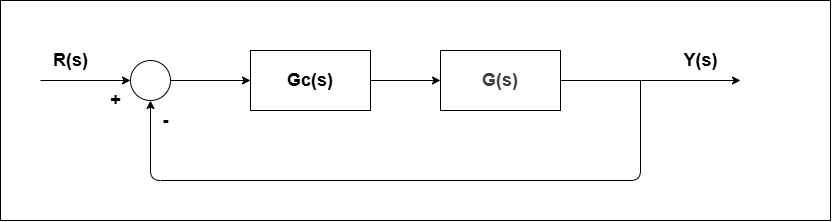

In [3]:
Image(filename='figs/diagrama_de_blocos.drawio.png')

### Função de transferência do sistema

A função de transferência da tensão do estator para a velocidade angular do eixo do motor utilizando as equações do modelo físico e considerando condições iniciais nulas é dada por: